In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import numpy as np
from scipy.stats import boxcox
from scipy.stats import yeojohnson

warnings.simplefilter("ignore")
%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set(style="darkgrid")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
data = pd.read_csv("../data/test.csv", decimal='.')
data.head()

Id                                               Name  \
0   0                                     Помпа для воды   
1   1                                    Термопот BN-348   
2   2          NEOLUX HLG-69 HEPA фильтр для пылесоса LG   
3   3                               Аппарат для педикюра   
4   4  Пульт Huayu H-LCD1510 (20LJ02) для телевизоров...   

                                            Category   Brand  \
0  /Техника для кухни/Приготовление напитков/Помп...  Majava   
1  /Техника для кухни/Приготовление напитков/Терм...    Beon   
2  /Техника для дома/Аксессуары для пылесосов/Фил...  NEOLUX   
3  /Красота и здоровье/Косметические аппараты/Апп...  CENTEK   
4  /Техника для дома/Пульты управления/Пульты тел...   HUAYU   

                      Seller Color  Comments  Final price  Max price  \
0    Бобров Вячеслав Юрьевич   NaN       2.0        277.0      277.0   
1                ТЕХПРОМ ООО   NaN       5.0       2211.0     2211.0   
2        ПКФ НЕВА-ФИЛЬТР ООО   NaN      19.0        490.0      490.0   
3                ЛИВСИТИ ООО   NaN       2.0        807.0      807.0   
4  Дулгер Дарья Сергеевна ИП   NaN       3.0        426.0      440.0   

   Min price  Average price  Days in stock  Days with sales  Rating  \
0      250.0     266.290323           16.0               14  0,0000   
1     2211.0    2211.000000            7.0                8  3,0000   
2      450.0     476.884615           31.0               22  5,0000   
3      807.0            NaN           31.0                0  4,0000   
4      426.0     426.000000           31.0                5  5,0000   

   Basic Sale  Basic Sale Price  Base price  \
0        50.0             360.0       720.0   
1        40.0            2664.0      4440.0   
2        30.0             490.0       700.0   
3        15.0             807.0       950.0   
4         3.0             426.0       440.0   

                                       full_category  
0  Бытовая техника/Техника для кухни/Приготовлени...  
1  Бытовая техника/Техника для кухни/Приготовлени...  
2  Бытовая техника/Техника для дома/Аксессуары дл...  
3  Бытовая техника/Красота и здоровье/Косметическ...  
4  Бытовая техника/Техника для дома/Пульты управл...

In [22]:
section = data['full_category'].str.split('/').apply(lambda x: x[0])
sub_section = data['full_category'].str.split('/').apply(lambda x: x[1])
extra_section = data['full_category'].str.split('/').apply(lambda x:  x[len(x) - 1])

data["Section"] = section
data["SubSection"] = sub_section
data["ExtraSection"] = extra_section

extra_uniques = data['ExtraSection'].value_counts()
same_count = data['ExtraSection'].apply(lambda x: extra_uniques[x] if x != "None" else 0)

data["Similar"] = same_count

def stats(df):
    total=df.isnull().sum().sort_values(ascending=False)
    percent=total/len(df)*100
    temp=pd.concat([total, percent], axis=1, keys=['Total', '%'])
    temp=pd.concat([temp, df.dtypes], axis=1)
    return temp.loc[(temp['%']>0)]
print(stats(data))

def averagePrice(x):
    if np.isnan(x['Average price']):
        return (x['Max price'] + x['Min price']) * 0.5
    else:
        return x['Average price']

data['Average price']= data.apply(lambda x : averagePrice(x),axis=1)
data = data.drop(columns=["Max price", "Min price", "Final price"])
data.fillna('Nan', inplace=True)

data['Rating'] = data['Rating'].str.replace(',','.').astype(float) - 3

print(stats(data))

               Total          %        0
Color          10673  99.366912   object
Average price   2407  22.409459  float64
Seller             7   0.065171   object
Empty DataFrame
Columns: [Total, %, 0]
Index: []


In [23]:
section_map = {}

def fill_map(x):
    if x in section_map.keys():
        return x
    similar = data.loc[data["ExtraSection"] == x]
    section_map[x] = similar
    return x

data['ExtraSection'].apply(lambda x: fill_map(x))

def get_price_scale(x):
    section = section_map[x["ExtraSection"]]
    
    min_price = section["Average price"].min()
    max_price = section["Average price"].max()
    current_price = x["Average price"]

    return np.clip((current_price - min_price) / (max_price - min_price), 0, 1) - 0.5


data["Price scale"] = data.apply(lambda x: get_price_scale(x), axis=1).astype(float)

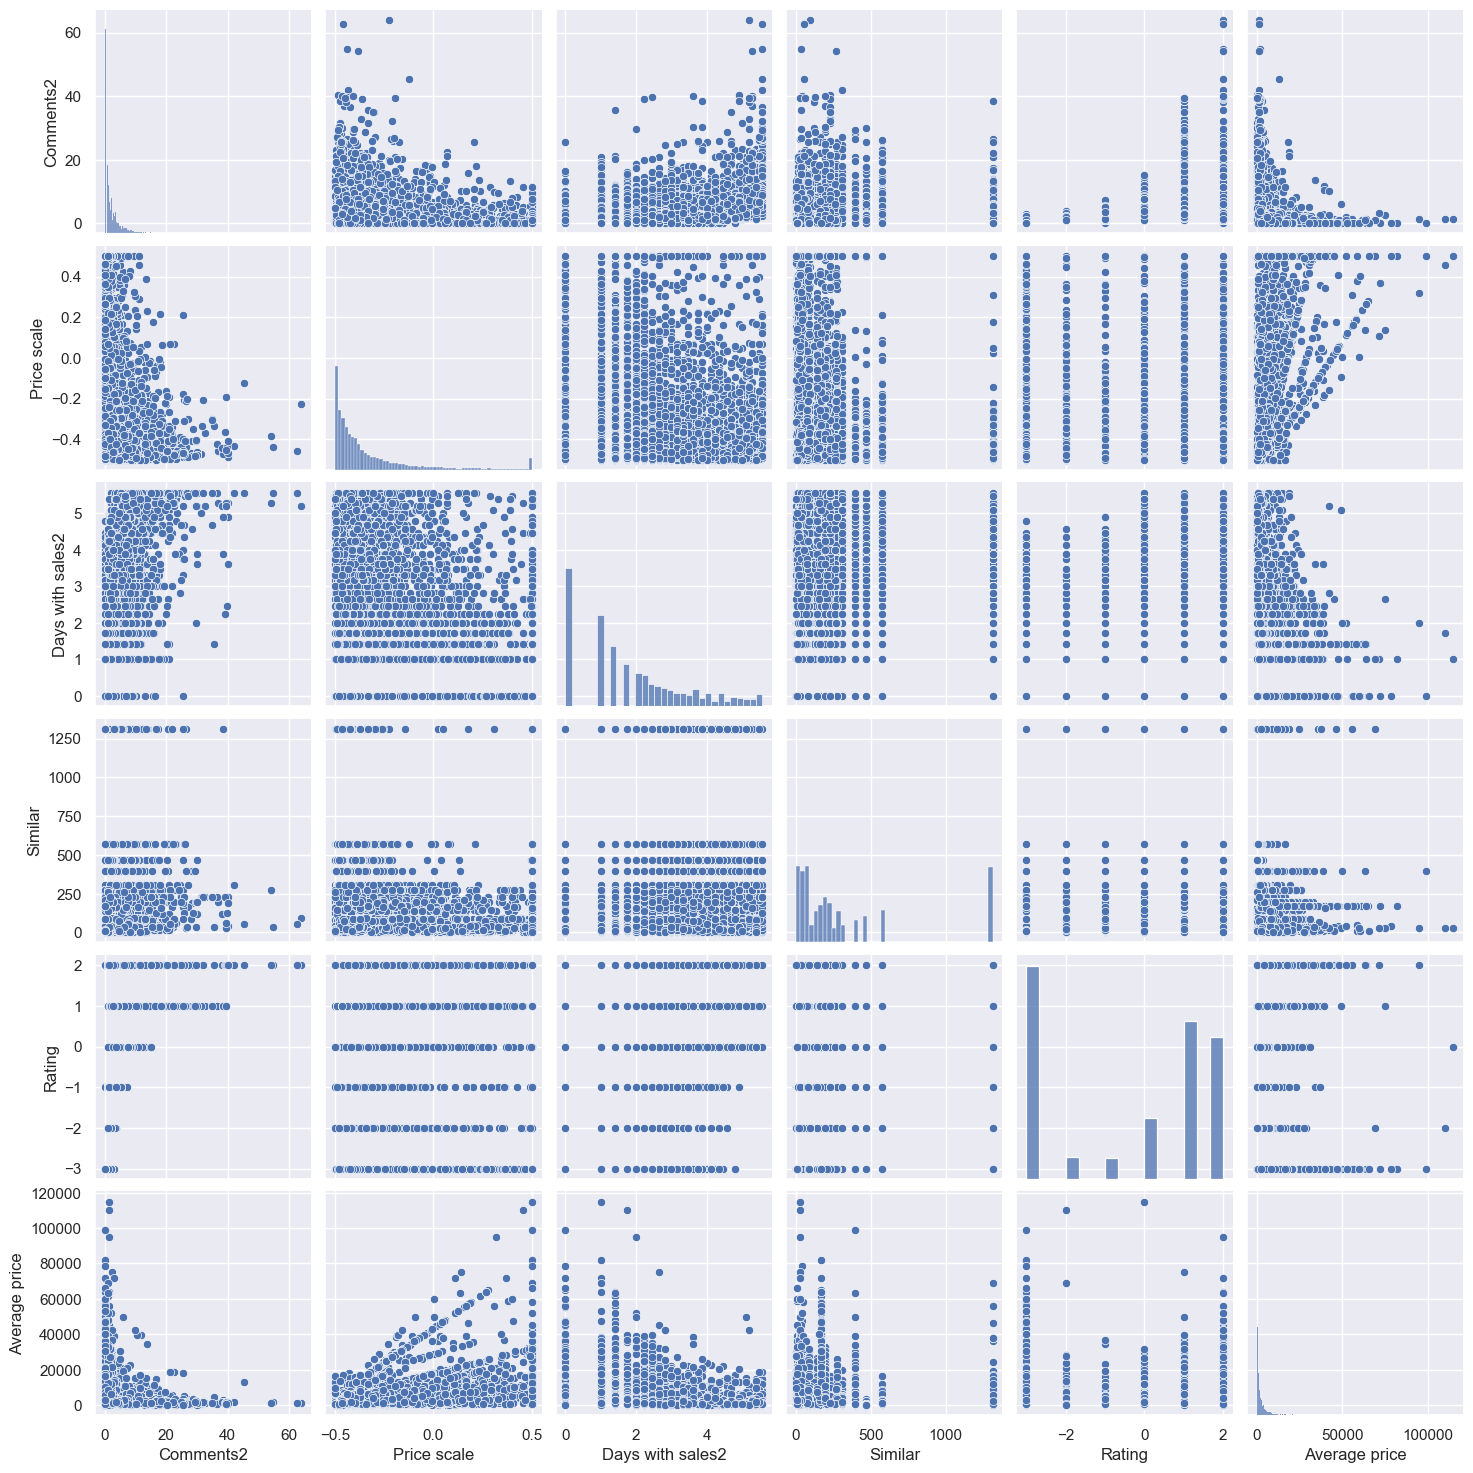

In [19]:
data["Comments2"] = data["Comments"] ** (1/2)
data["Days with sales2"] = data["Days with sales"] ** 0.5

sns.set()
cols = ['Comments2', 'Price scale', 'Days with sales2', 'Similar', 'Rating', 'Average price']
sns.pairplot(data[cols], size = 2.5)
plt.show()